# Advanced Machine Learning - programming assignment 1

*Due: Friday December 3rd*

**Please fill in:**
* Simon van de Fliert (5708656)
* Dirk Keller (4282264)

### Further instructions:
* Make sure your code is properly commented.
* Submit your code in Blackboard using **one** of your accounts; we will put the grade in Blackboard for the other team member as well.

## Multi-armed Bandits

In this programming assignment, we will look at how we can solve a k-armed bandit problem as discussed in the lecture. Expect for winning at the slot machines, you are expect to better understand the tradeoff between exploration and exploiation. 

Here are the objectives of this assignment:
1.   Get familier with the Open-AI gym environment,
2.   Implement your own k-armed bandit environment based on the gym framework,
3.   Use an epsilon-greedy algorithm to find the optimal action for this k-armed bandit problem,
4.   Play with the parameter epsilon and identify a reasonable setting for balancing exploration and exploiation. 
    

### 1. Let's start with the OpenAI gym

Gym (https://gym.openai.com/) is a wide-used toolkit for developing and comparing reinforcement learning algorithms. 

1. Gym makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano. 

2. The gym library is a collection of test problems — **environments** — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

First, we download & install the gym library. 

In [1]:
#!pip install gym

In [2]:
#!pip install huggingface-hub==0.0.8

**Great!** Now let's import the gym class and work on a basic example of gym code.


In [1]:
import gym

Like mentioned above, gym's main purpose is to provide a large collection of **environments** that expose a common interface. You can find a listing of those environments below (they are Markov decision process(MDP) enviroments and we will discuss MDP in our lecture), as follows:

In [2]:
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v1), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v1), EnvSpec(FrozenLake-v1), EnvSpec(FrozenLake8x8-v1), EnvSpec(CliffWalking-v0), EnvSpec(Taxi-v3), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSpec(Swimmer-v3), EnvSpec(Walker2d-v2), EnvSpec(Walker2d-v3), EnvSpec(Ant-v2), EnvSpec(Ant-v3), EnvSpec(Humanoid-v2), EnvSpec(Humanoid-v3), EnvSpec(HumanoidStandup-v2), EnvSpec(FetchSlide-v1), EnvSpec(FetchPickAndPlace-v1), EnvSpec(FetchReach-v1), EnvSpec(FetchPush-v1), EnvSpec(HandReach-v0), EnvSpec(HandManipula

We are now going to explain how the RL framework of gym works. 
- An **ENVIRONMENT**, 
- You also have an **AGENT**,
- The agent takes an **ACTION**, in our case, 10 actions are possible to take,
- When a single **ACTION** is chosen and fed to our **ENVIRONMENT**, the **ENVIRONMENT** measures how good the action was taken and produces a **REWARD**, which is usually a numeric value.

In MDP problems, the **ENVIRONMENT** will also provides an **OBSERVATION**, which represets the state of the **ENVIRONMENT** at the current moment. In the multi-armed bandit problems, there is no **OBSERVATION** (or state). You may understand this better after the lecture about Markov decision process (MDP). 

Please read the 'Getting Started with gym' https://gym.openai.com/docs/ for better understanding the framework. 

### 2. Implement your own environment

Unfortunatley, gym does **NOT** provide a multi-armed bandit environment. Therefore, we are going to implement our own environment following the framework of gym. This enviroment is a gambiling room with ten different slot machines (a 10-armed bandit problem). Similar with examples given in the lecture, the reward of each slot machine follows a normal distribution, but the average reward (mean) and variance of each action are different. Your goal is to determine the optimal action from all possible actions/machines. 

The core gym interface is **Env**, which is the unified environment interface. There is no interface for agents. The following are the Env methods you should know:

- `step(self, action)`: Steps the environment by one timestep. Returns observation, reward, done, info.
- `reset(self)`: Resets the environment to an initial state. Returns an initial observation. Each call of `reset()` should yield an environment suitable for a new episode, independent of previous episodes. Because there is no state transition in multi-armed bandit problems, this function is not used here.
- `render(self, mode='human')`: Renders one frame of the environment. The default mode will do something human friendly, such as pop up a window. In this assignment, there is no need to create a pop up window. 

Before writing your own codes, read through the readme of github page of gym https://github.com/openai/gym. You are also recommended to read at least the codes for one simple environment and one example agent.

#### 2.1 Self-defined Slot Machine

**Please fill in the missing codes in the function sample (1 point).**

In [16]:
import numpy as np

class slotMachine:
    """
        A slot machine contains a reward distribution that randomly generated with restricted mean and standard deviation. 
            sample function: generates a reward at each time step based on the given reward distribition
    """
    def __init__(self):
        self.mu = np.random.uniform(-5, 5)  # mean
        self.sigma = np.random.uniform(0.5, 1)  # standard deviation

    def sample(self):
        #the Step function returns four pieces of information, of which the second is the most interesting here, as that indicates the reward of taking said step.
        reward = np.random.normal(self.mu, self.sigma)
        return reward

#### 2.2 Game Environment
**Please fill in the missing codes in function step (1 point) in the environment.** 

In [17]:
from gym import spaces

# The environment has to inherit the interface of gym.Env
class GamblingRoom(gym.Env):
    """
    A k-armed bandit environment: a gambling room with slot machines, allows the agents to interact with it.
        r_machines: A list of slot machines, each gamblingRoom contains k number of slotMachines
    """
    def __init__(self, k):
        # initialize reward distribution for each action/machine
        self.r_machines = []
        for i in range(k):
            # each gamblingRoom contains k number of slotMachines
            self.r_machines.append(slotMachine())

        self.num_arms = k
        self.action_space = spaces.Discrete(self.num_arms)
        self.observation_space = spaces.Discrete(1)
        # for our bandit environment, the state is constant
        self.state = 0
        self.seed()
    
    # step up the environment based on the selected action,
    # return the constant state, reward, done = false, and info 
    # for now, we do not have to worry about the DONE and INFO variables.
    def step(self, action):
        assert self.action_space.contains(action)
        done = False

        # Get the slotMachine corresponding with the chosen action
        chosen_machine = self.r_machines[action]
        reward = chosen_machine.sample()

        #reward = slotMachine.sample(chosen_machine)
        return self.state, reward, done, {}

    
    def seed(self, seed=None):
        pass
    
    def reset(self):
        pass

    def render(self, mode='human', close=False):
        pass

    def close(self):
        pass

    # get the mu values of each slotmachine to later calculate the percentage of optimal actions chosen by the agent
    def get_opt_action(self):
        
        mu = [slot_maschine.mu for i, slot_maschine in enumerate(self.r_machines)]
        max_mu = max(mu)  
        index_max_mu = mu.index(max_mu)
        
        return index_max_mu

    

### 3. Implement an agent with the epsilon greedy algorithm

In this part, you are expected to implement an RL agent. To decide the action to take at each time step, this agent uses the epsilon greedy algorithm introduced in the lecture.

**Please fill in the missing codes in function select_action (1.5 points) and update_parameters (1 point) in the agent.** Feel free to import the needed packages if there are any.

In [18]:
class EplisonGreedyAgent:
    def __init__(self, k, e):
        # set up the number of arms/actions
        self.num_arms = k
        # set up the value of epsilon
        self.epsilon = e
        # init the estimated values of all actions
        self.Qvalues = np.zeros(k)
        # init the numbers of time step that every action is selected
        self.stepSize = np.zeros(k)

    ##
    # select the action to take at the current time step
    # (for MDP, choose the action based on state; for k-armed bandit, no state given)
    # return: the action to take
    ##
    def select_action(self):
        action = None

        # Choose the strategy between exploration or exploitation, this is based on the epsilon value from the epsilon-greedy algorithm
        strategy = np.random.binomial(1, self.epsilon)
        exploration = 1

        if strategy == exploration:
            #select a random action to let the agent explore the environment
            action = np.random.choice(self.num_arms)
        
        # Select the best action based on the Argmax of the best Qvalue
        else:
            # Get the Argmax from the list of Qvalues, as this lets the agent exploit its knowledge
            maximum = np.amax(self.Qvalues)
           
            # After getting the argmax value, we get the index corresponding to that value to get the correct action
            max_actions = np.where(self.Qvalues == np.amax(maximum))
            # If multiple actions have the same max value, then pick a random one
            action = np.random.choice(max_actions[0])

        # increment the stepSize numpy array for the chosen action
        self.stepSize[action] += 1

        # return welke slotmachine gekozen wordt
        return action


    ##
    # Update the Q-values of the agent based on received rewards
    # input: action_index = the action, reward = the reward from this action
    # return: null
    ##
    def update_parameters(self, action, reward):                
        # Update the Qvalue index with the following formula     
        self.Qvalues[action] = self.Qvalues[action] + (1 / self.stepSize[action]) * (reward - self.Qvalues[action])


### 4. Run the simulation, play with parameters and analyse results

Finally, we write codes for running the simulation. 

In order to decrease the effect of randomness, we usually conduct multiple simulation runs and average the results. In the implementation, you may start with one run, then use the variable `num_runs` for running multiple simulations.

In each run, you shall setup the `epsilon` and number of time step `num_episodes` (0.01 and 500 by default). Then, after the initlization of our agent and environment, **please fill in the missing codes (with ??? or TODO: to be filled). (2.5 points)**

In [24]:
# For visualizations
from matplotlib import pyplot as plt
import random

def GamblingRoomSeeded(seed):
    num_action = 10
    num_seed = seed
    num_runs = 100  # number of simulation runs
    num_episodes = 2000 # number of steps in each run

    epsilons = [0, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.5]

    # set up the random seed
    np.random.seed(num_seed)

    # init the environment
    env = GamblingRoom(num_action)

    # delete the wrap
    env = env.unwrapped

    # show the action space
    print(env.action_space) 

    # used for later plots
    plt.figure(figsize=(23,10))
    plt.suptitle(f'The Averaged Rewards for Seed {seed} ', fontsize=30)

    #to keep track of the number of optimal actions chosen over all epsilons --> This will be used in creating the subplots for later analysis 
    epsilon_option_action_freq_table = []
    # run for different values of epsilon
    for i, epsilon in enumerate(epsilons):
        
        reward_tracker = []
        
        # To keep track of optimal actions taken over runs per epoch
        freqtable_opt_action = [0]*num_episodes
        # run multiple simulations
        for i_run in range(num_runs):

            # init the epsilon-greedy RL agent 
            agent = EplisonGreedyAgent(k=num_action, e=epsilon )

            # Get the optimal action/slotmachine 
            opt_action = env.get_opt_action()

            # in each simulation run, loop the action selection
            for episodes in range(num_episodes):
                #Get the action from the epsilon greedy algorithm
                action = agent.select_action()

                #Get the reward corresponding with the action
                observation, reward, termination, additional_information = env.step(action)

                #Update Qvalues
                agent.update_parameters(action, reward)
                
                # Save rewards of each episode --> This will result in a list of len(num_episodes) with the rewards for each timestep
                if i_run == 0:
                    reward_tracker.append(reward)
                else:
                    reward_tracker[episodes] += reward

                if action == opt_action:
                    freqtable_opt_action[episodes] += 1

        #transform the frequency table for easy plotting later
        freqtable_opt_action = (np.array(freqtable_opt_action))

        # save the frequency table of optimal actions for this specific epsilon in a list that will not be overwritten with every new epsilon run
        epsilon_option_action_freq_table.append(freqtable_opt_action)

        for idx, element in enumerate(reward_tracker):        
            reward_tracker[idx] = reward_tracker[idx]/num_runs

        # We use this to make the axis of the subplots consistent
        if i==0:
            max_y = np.max(reward_tracker)

        c = (random.random(), random.random(), random.random())    
            
        plt.subplot(2, 4, i+1)
        #ylim is used to standardize the y-axis of each subplot in order to make comparing the different plots easier
        plt.ylim(0, max_y + 1.5)
        plt.plot(range(num_episodes), reward_tracker, color = c);
        plt.title(label=f"Epsilon value {np.round_(epsilon, decimals=4)}")
        plt.xlabel("Steps")
        plt.ylabel("Average Reward")
        plt.tight_layout()
        plt.grid(axis = 'y')
        plt.subplots_adjust(top=0.85)

    plt.show()
    
    plt.figure(figsize=(23,10))
    plt.suptitle(f'The Percentage Optimal Actions chosen for Seed {seed} ', fontsize=30)
    # plot the percentage of optimal actions taken
    for i, epsilon in enumerate(epsilons):
        c = (random.random(), random.random(), random.random())    

        plt.subplot(2, 4, i+1)
        plt.plot(range(num_episodes), epsilon_option_action_freq_table[i], color = c);
        #ylim is used to standardize the y-axis of each subplot in order to make comparing the different plots easier
        plt.ylim(0, num_runs)
        plt.title(label=f"Epsilon value {np.round_(epsilon, decimals=4)}")
        plt.xlabel("Steps")
        plt.ylabel("%\ optimal action")
        plt.tight_layout()
        plt.grid(axis = 'y')
        plt.subplots_adjust(top=0.85)

    plt.show()
    
    env.close()

    

### Seed 2 and Seed 4 Results

Discrete(10)


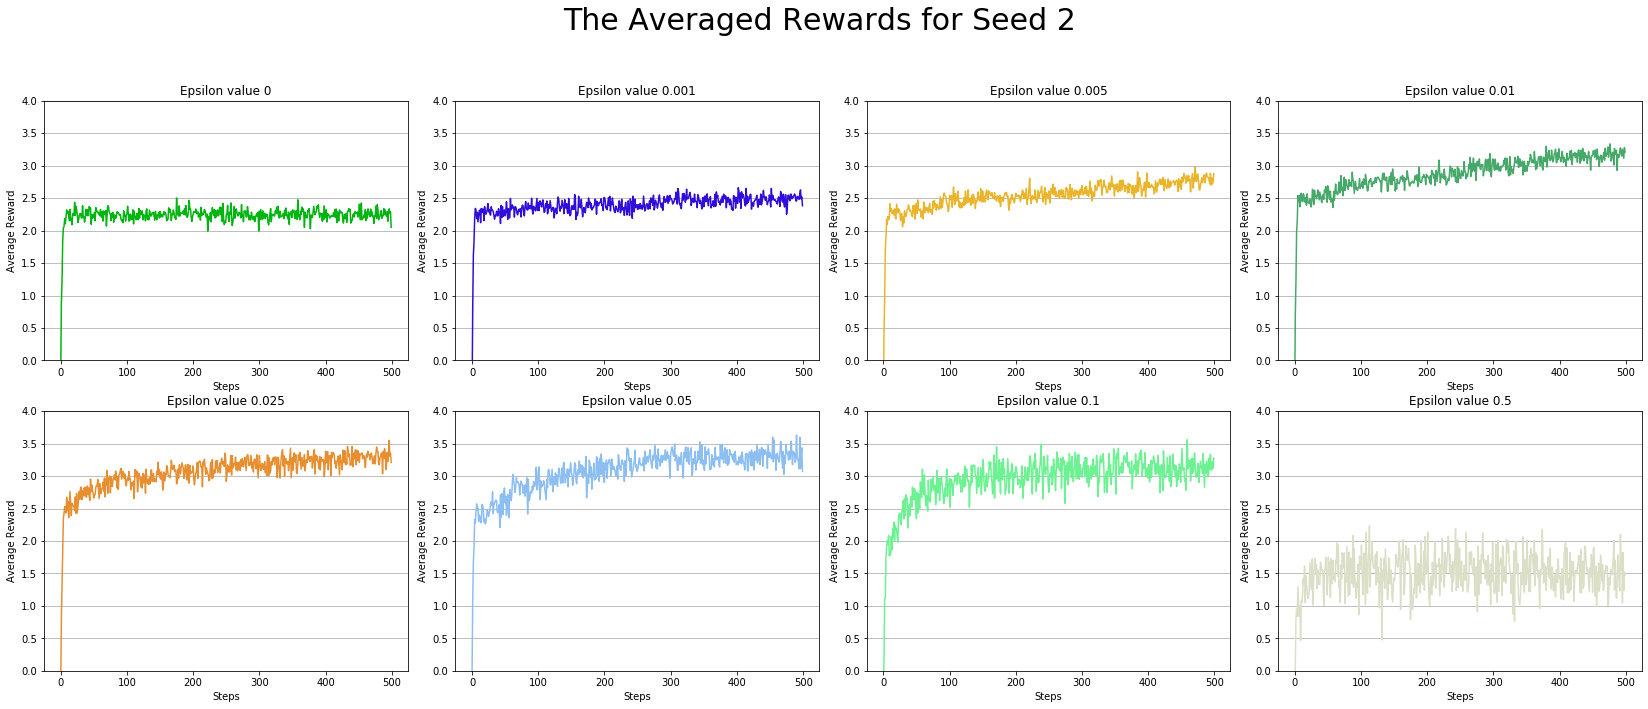

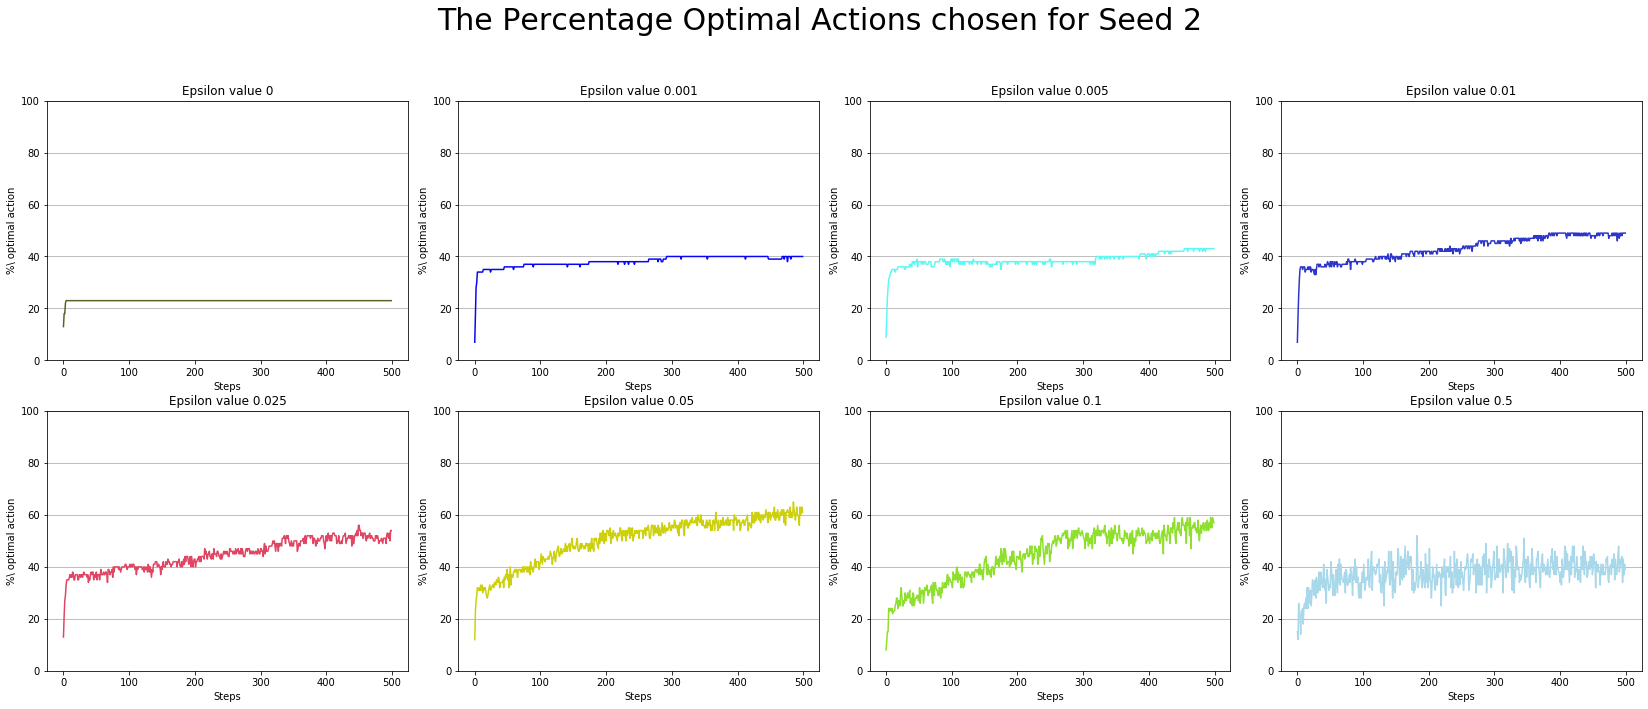

In [9]:
GamblingRoomSeeded(2)

Discrete(10)


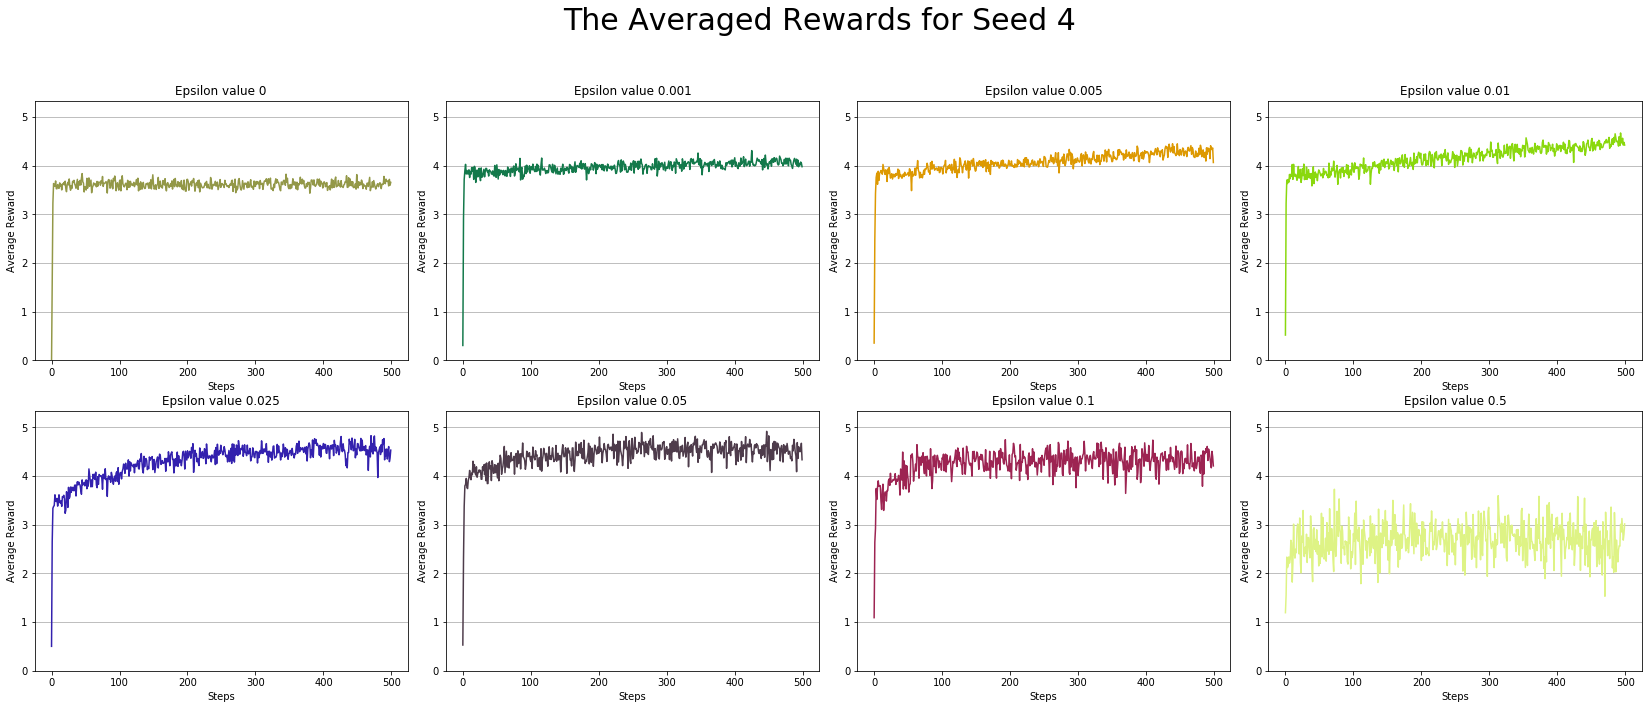

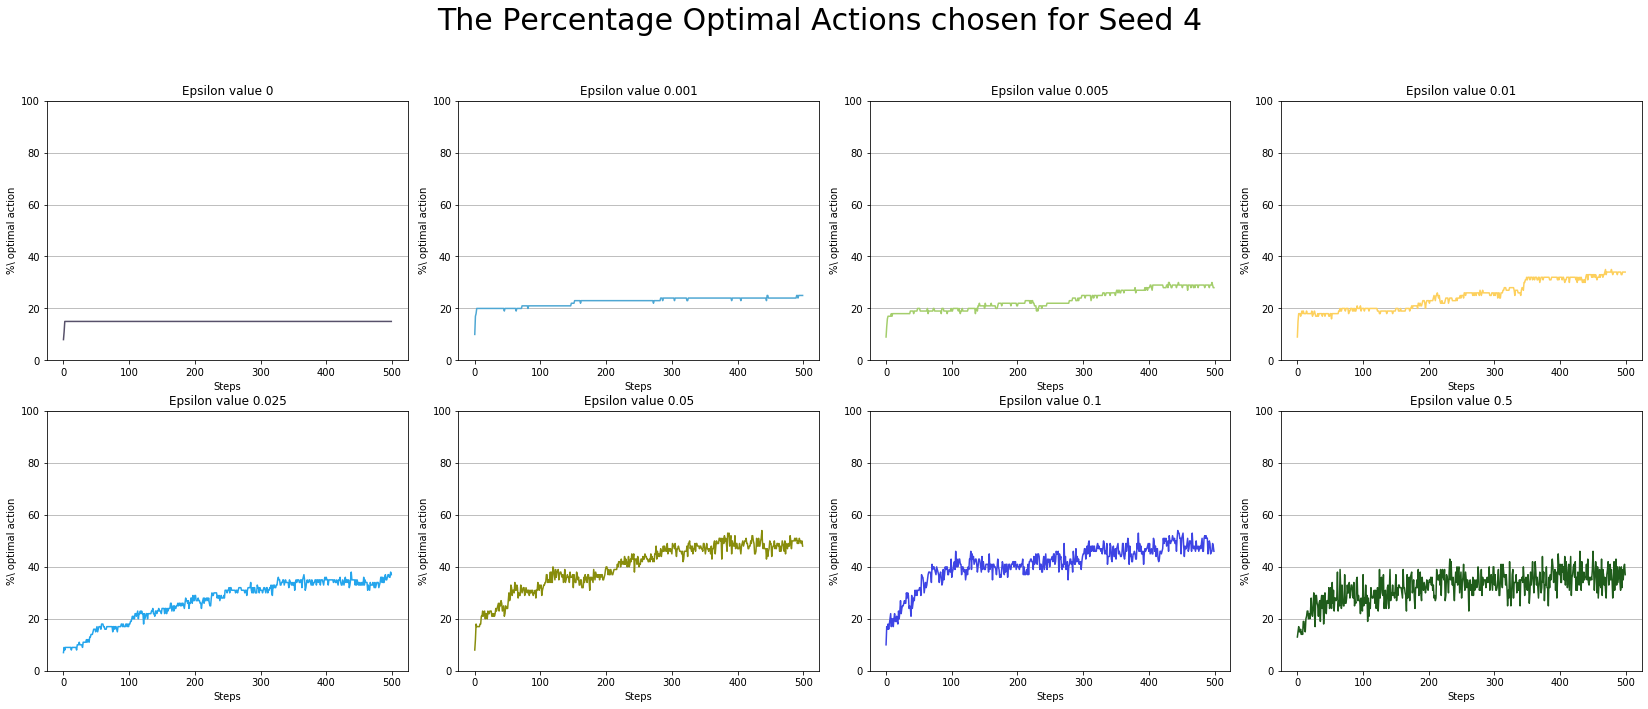

In [8]:
GamblingRoomSeeded(4)

Now it's time to examine the performance of algorithms with different epsilon values (different exploration strategies) in multiple simulation runs. 

You shall play with the parameter epsilon under 2 or 3 different gambling environments (by initlizing different reward distributions for machines). **For each environment, try at least 2 different values of epsilon and identify a reasonable epsilon value that could balance the exploration and exploiation**. Instead of handing in your codes for this part, please select one environment you have tested and describe your environment and experimental settings **(1 point)**. Then, provide an explanation on how you identify the good epsilon value in this environment and why it is a good one **(1 point)**. 

Few instructions:
- Your answer shall include two plots presenting compariable measures of the different epsilon settings (e.g. the average reward per step and % of optimal action). **(1 point)** 
- You shall present the average results from at least 100 simulation runs. Remember that the gambling environment CANNOT be changed over those runs used for calculating the average results. 
- You may adjust the total time steps when the learning needs more time for a certain epsilon value, but do not over spend your time on this.    

### K-armed bandit performance analysis
The k-armed bandit algorithm was simulated in three different environments by initializing slot machines (**k** = 10) with different values for the Gaussian parameters ($\mu$, $\sigma$) in different seeds ($s_{2}$, $s_{3}$, $s_{4}$). 

#### 1. Epsilon and Performance Measures.
The performance measures (average reward and percentage optimal action selected) for different seeds can be seen in the subplot groups above ($s_{2}$ and $s_{4}$), and the chosen seed to highlight ($s_{3}$) below. In each subplot group eight different $\epsilon$ values (0, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.5) are tested. For example for $s_{3}$, when $\epsilon$ = 0**, the  selected action improves the fastest for both the average reward and the percentage optimal actions selected, however, the greedy agent quickly becomes stuck in persistently selecting a suboptimal action (or slot machine). When $\epsilon$ > 0, the agent performs exploration with a probability of 1-$\epsilon$ (selecting a random action from a homogenous distribution); As demonstrated in the figures, exploration helps the $\epsilon$-greedy agent to improve on both performance measures. Importantly, with an increasing value of $\epsilon$, the plots demonstrate a trade-off between run-time efficiency and (both) performance measures:

* The $\epsilon$ = 0.1 method explored more, and usually found the optimal action earlier, but it never selected that action more than 91% of the time. 
* The $\epsilon$ = 0.01 method improved slower, but eventually would perform better than the $\epsilon$ = 0.1 method on both performance measures.

More specifically, the (potential) maximal performance would be 99,2% for the $\epsilon$ = 0.01 method for a given seed. However, the agent would need to have more than 500 episodes (learning trials) with a very high exploration rate. (refer to the third plot below). The best epsilon value is a value between 0.01 and 0.1, because out side of this range the trade-off unreasonably favours either accurcy or speed, respectively, with a extrem malus for the other measure (e.g. the smal gain in speed outside of this range does not justify the enormous loss in accurracy). However, the exact choice for the value, again, depends on the goal and context of application (e.g. larger value if computational efficiency is more important than trade off.) However, with every increase in $\epsilon$, the potential maximal performance (= 1 - $\epsilon$ + $\frac{\epsilon}{k}$) decreases with too large values (e.g. $\epsilon$ = 0.5) being unreasonable for any application context; similarly, the spikes grow larger (since a higher probability for a random action introduces more variance in the average across runs for the given episode).


#### 2. (Bonus) Reasoning behind the performance of the percentage of optimal actions chosen
When initializing different environments, both performance metrics change: different values for the reward, due to the difference in distribution, and, most notably, the performance on the optimal action chosen, with substantial drop in performance in $s_{2}$ and $s_{4}$. On possible explanation is that the Gaussian distribution of the most-optimal action (or slot machine) overlaps more with the distribution of the second-most-optimal action, or with even more suboptimal actions (e.g. the expected reward value of the best slot machine has $\mu$ = 4, and the second best slot machine has $\mu$ = 3.99). This could give the agent a hard time in consistently choosing the action with the optimal expected reward and lowers the final value. Here this second performance measure is more strongly impacted by the overlap in distributions because it is binary (the agent either selected the most optimal action or not) and it does not matter, whether the agents preferred (but suboptimal) action is almost as good as the optimal one. 

This is most likely a sample problem, since the agents of estimation of the action value tries to approximate the true value of the environment (the $\mu$ of all slot machines for a given seed). If the agent would have more time (more samples/episodes) to get a more precise estimate of the true value, the agent might ultimately arrive at consistently choosing the optimal action. Two arguments might support this claim:
* The graph sometimes shows abrupt decreases in the performance measure. The agent might drop here his preference for a close to optimal action for the sake of a better one. This sub-optimal action might lie close to the optimal action but due to sampling error suggested a higher expected value than it actually had, which was revealed with a more representative sample after several episodes. 
* Furthermore, for all $\epsilon < 0$, the percentage of optimal action chosen does monotonically increase (faster for a higher value of $\epsilon$ than for a lower one; see the figure beneath). The agent might often switch between the top optimal actions that overlap closely in their distribution, however with an increasing sampling size, hence a more precise approximation of the true value ($\mu$ of the slot machine), slowly but surely favouring the optimal action more often.

Discrete(10)


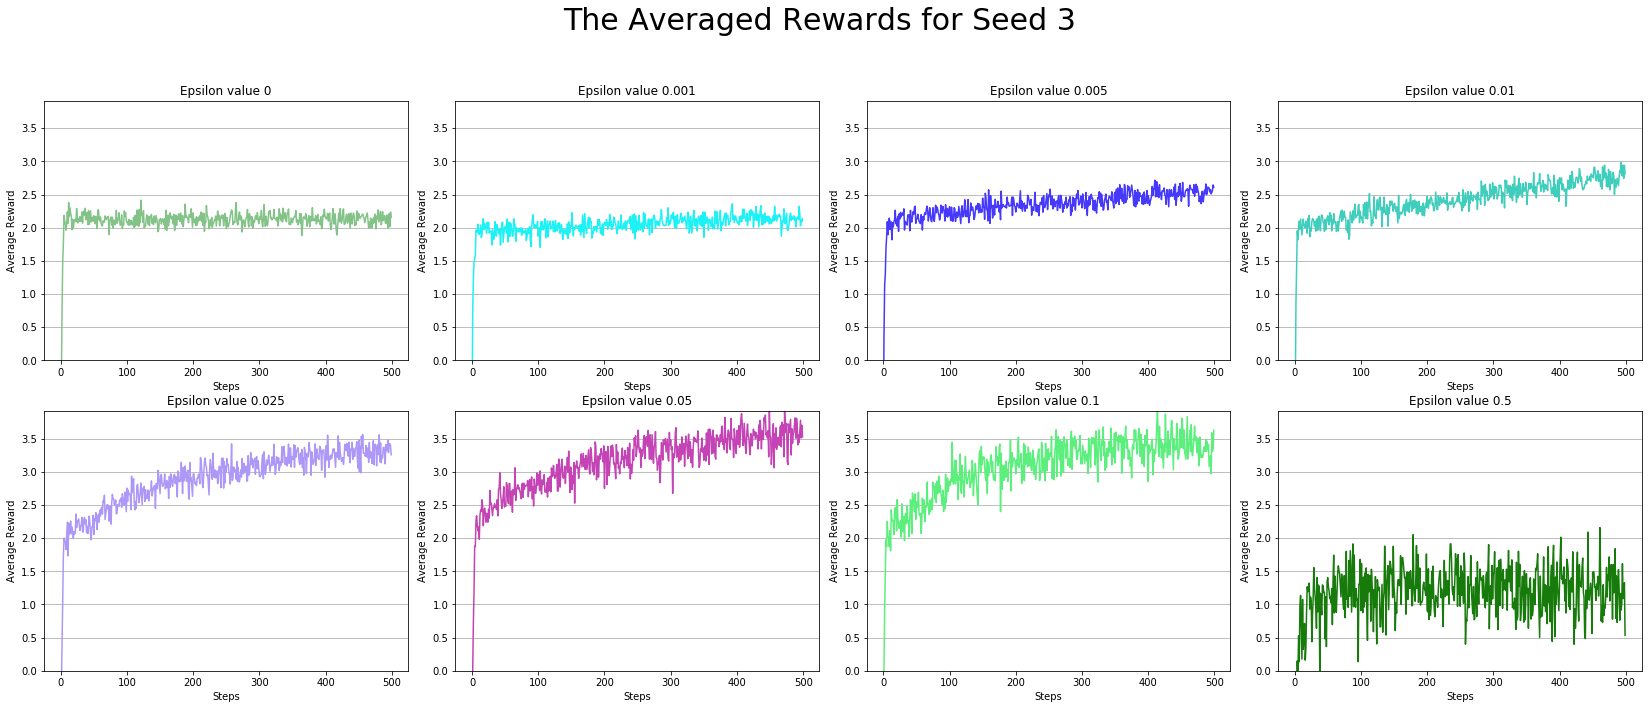

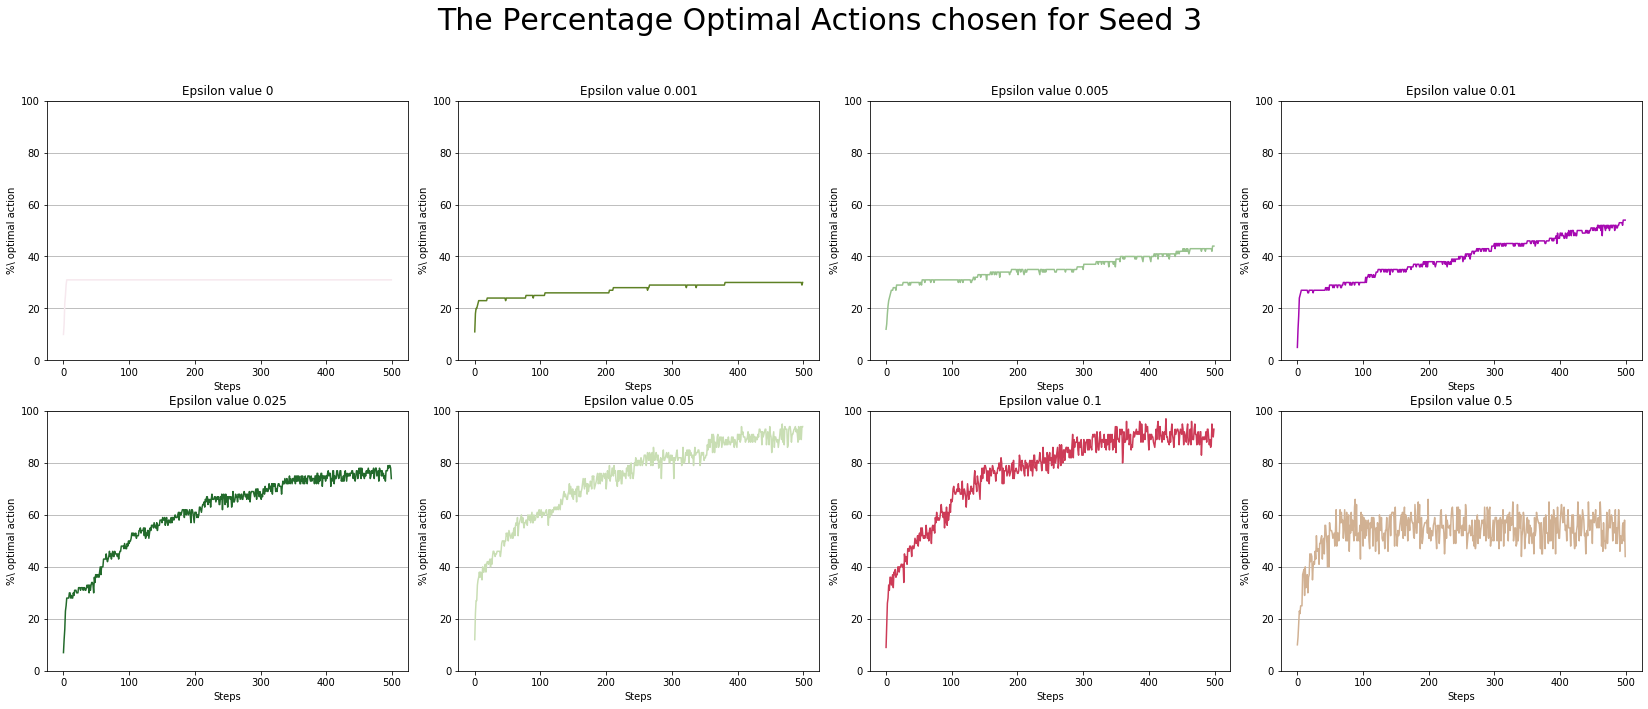

In [7]:
GamblingRoomSeeded(3)

### Running the agent with 2000 epsiodes

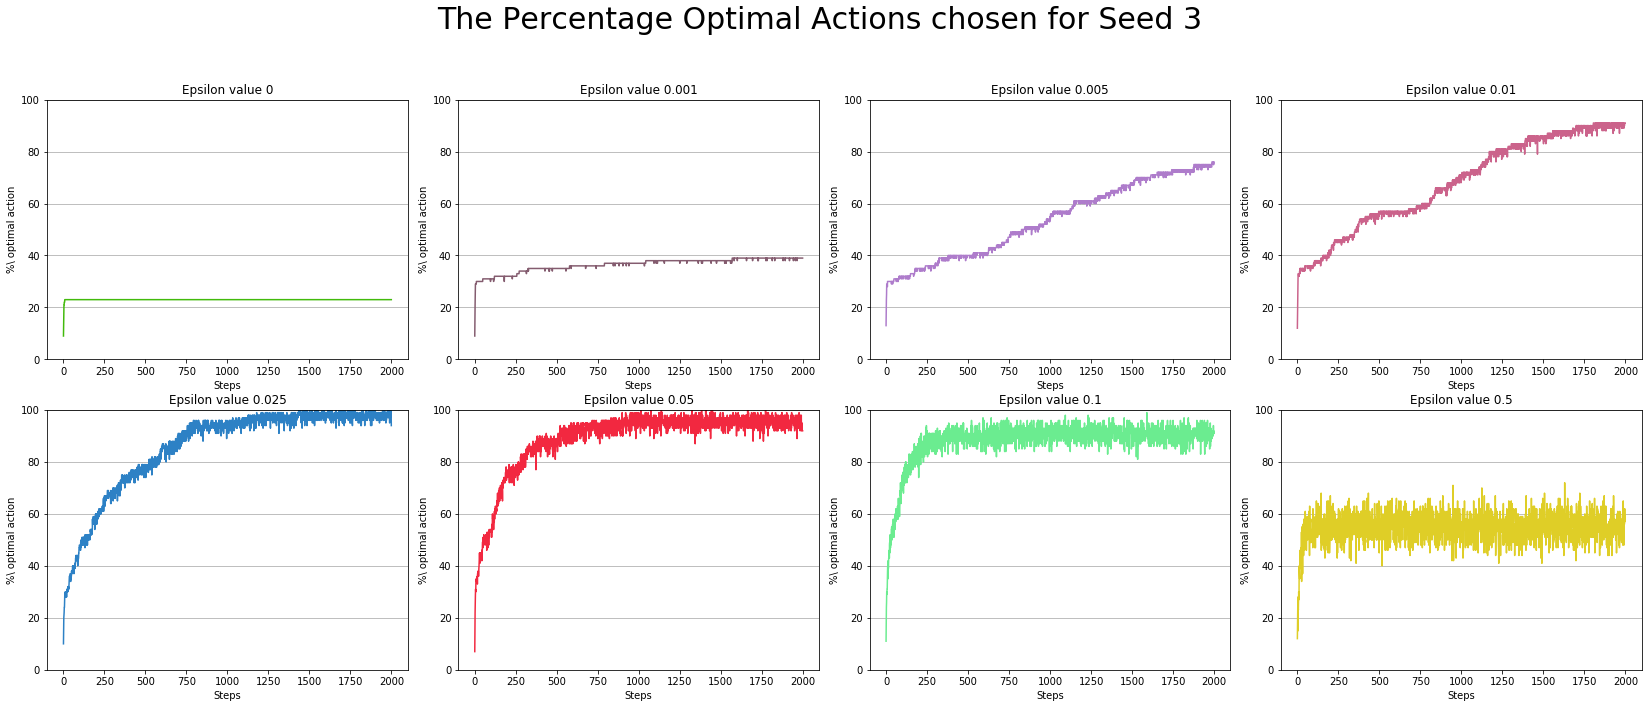

In [26]:
from IPython import display
display.Image("./PCA_2000.PNG")

You are almost done! Before handing in, make sure that the codes you hand in work, and that all plots are shown. **Submit just one file per team.** Please make sure that you submit a .zip file with images.